# Travelling Salesman Problem Visualization


In [1]:
import plotly.express as px
import networkx.algorithms.approximation as nx_app
import timeit
import pandas as pd
from IPython.display import Video
import os
import imageio
from itertools import permutations
import matplotlib.pyplot as plt
import numpy
import networkx as nx
import math

import random
random.seed(2333)

numpy.random.seed(2333)


In [2]:
class TSP:

    def __init__(self, G):
        self.G = G
        self.pos = nx.get_node_attributes(self.G, "pos")
        self.G_ad = nx.to_numpy_array(self.G)

    def _dist_btw_nodes(n1, n2):
        return math.hypot(n1['pos'][0]-n2['pos'][0], n1['pos'][1]-n2['pos'][1])

    def visualize(self, edges=[]):
        plt.figure(figsize=(24, 24), dpi=32, frameon=True)
        plt.autoscale(enable=False)
        nx.draw_networkx(
            G=self.G,
            pos=self.pos,
            edgelist=edges,
            node_size=2400,
            font_size=24,
            width=4,
            font_color='white',
            node_color='black',
            font_weight='bold',
            edge_color='blue',
        )

    def brute_force(self):
        travelNodes = {i for i in self.G.nodes()}
        travelNodes.remove(0)  # Start at node 0

        minLength = 2**63-1
        minPath = []
        history = []

        routePermutations = permutations(travelNodes)
        for route in routePermutations:

            length = 0

            currentNode = 0
            for node in route:
                length += self.G_ad[currentNode][node]
                currentNode = node
            length += self.G_ad[currentNode][0]

            if length < minLength:
                minLength = length
                path = ([0]+list(route)+[0])
                minPath = path
                history.append(path.copy())

        return minLength, minPath, history

    def nearest_neighbour(self, startNode=None):
        travelNodes = {i for i in self.G.nodes()}
        if not startNode:
            startNode = random.choice(tuple(travelNodes))
        travelNodes.remove(startNode)  # Random startNode

        path = [startNode]
        length = 0
        currentNode = startNode
        history = [[startNode]]

        while len(travelNodes) > 0:

            next_node = None
            distance = 2**63-1

            for node in travelNodes:
                history.append(path+[node])
                if self.G_ad[currentNode][node] < distance:
                    distance = self.G_ad[currentNode][node]
                    next_node = node

            length += distance
            path.append(next_node)
            travelNodes.remove(next_node)
            currentNode = next_node

        length += self.G_ad[path[-1]][startNode]
        path.append(startNode)
        history.append(path.copy())

        return length, path, history

    def christofides(self):
        pass

    def minimal_spanning_tree(self):
        pass

    def prims_algo(self):
        visited = [0]
        edge_list = []
        while len(visited) < len(self.G_ad):
            distance = 2**63-1
            next_edge = None

            for n in visited:
                for i, v in enumerate(self.G_ad[n]):
                    if i not in visited:
                        if v < distance:
                            distance = v
                            next_edge = (n, i)

            edge_list.append(next_edge)
            visited.append(next_edge[1])
        return edge_list

    def gen_animation(self, history, name):
        if not os.path.exists(f'{name}/images'):
            os.makedirs(f'{name}/images')

        with imageio.get_writer(f'{name}/{name}.gif', mode='I', duration=0.2) as writer:
            for i, v in enumerate(history):
                tsp.visualize(path_to_edgelist(v))
                plt.savefig(f'{name}/images/{i}')
                plt.close()
                writer.append_data(imageio.imread(f'{name}/images/{i}.png'))
            for _ in range(5):
                writer.append_data(imageio.imread(
                    f'{name}/images/{len(history)-1}.png'))

        images = []
        for i, v in enumerate(history):
            self.visualize(path_to_edgelist(v))
            plt.savefig(f'{name}/images/{i}')
            plt.close()
            images.append(imageio.imread(f'{name}/images/{i}.png'))
        for _ in range(5):
            images.append(imageio.imread(
                f'{name}/images/{len(history)-1}.png'))
        imageio.mimsave(f'{name}/{name}.mp4', images)


In [3]:
def gen_tsp_graph(size):
    G = nx.random_geometric_graph(size, 0.2)
    pos = nx.get_node_attributes(G, "pos")
    for i in range(len(pos)):
        for j in range(i + 1, len(pos)):
            dist = math.hypot(
                pos[i][0] - pos[j][0], pos[i][1] - pos[j][1])
            G.add_edge(i, j, weight=dist)
    return G


def path_to_edgelist(path):
    return list(nx.utils.pairwise(path))


## Initial Setup


In [4]:
G = gen_tsp_graph(size=10)
tsp = TSP(G)


## Brute Force


In [5]:
length, path, history = tsp.brute_force()
tsp.gen_animation(history, 'brute_force')
print(length, path)


3.078097894275286 [0, 3, 6, 9, 8, 5, 1, 2, 4, 7, 0]


In [6]:
Video('brute_force/brute_force.mp4')


## Nearest Neighbour


In [7]:
length, path, history = tsp.nearest_neighbour(0)
tsp.gen_animation(history, 'nearest_neighbour')
print(length, path)


3.314333715878226 [3, 0, 7, 8, 5, 1, 2, 4, 9, 6, 3]


In [8]:
Video('nearest_neighbour/nearest_neighbour.mp4')


## Christofides Approximation

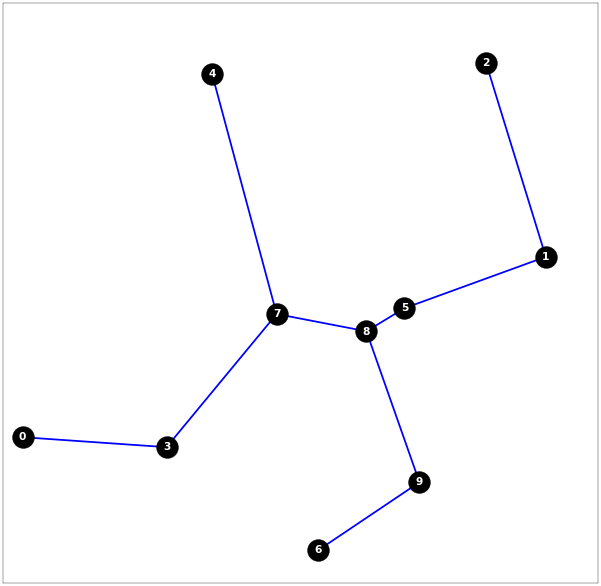

In [9]:
tsp.visualize(tsp.prims_algo())


## Runtime Comparison


In [ ]:
bf = []
nn = []
ch = []

for i in range(2, 13):
    G = gen_tsp_graph(size=i)
    tsp = TSP(G)

    start = timeit.default_timer()
    tsp.brute_force()
    end = timeit.default_timer()
    bf.append(end-start)

    start = timeit.default_timer()
    tsp.nearest_neighbour()
    end = timeit.default_timer()
    nn.append(end-start)

    start = timeit.default_timer()
    nx_app.christofides(G, weight="weight")
    end = timeit.default_timer()
    ch.append(end-start)


In [ ]:
data = {
    'Brute Force': bf,
    'Nearest Neighbours': nn,
    'Christofides': ch,
}
df = pd.DataFrame(data, index=[i for i in range(2, 13)])


In [ ]:
fig = px.line(df, title="Runtime Comparison for 2-12 Cities")
fig.update_xaxes(title="Amount of Cities")
fig.update_yaxes(title="Execution Time (s)")
fig.show()


In [ ]:
nn = []
ch = []

for i in range(10, 501, 10):
    G = gen_tsp_graph(size=i)
    tsp = TSP(G)

    start = timeit.default_timer()
    tsp.nearest_neighbour()
    end = timeit.default_timer()
    nn.append(end-start)

    start = timeit.default_timer()
    nx_app.christofides(G, weight="weight")
    end = timeit.default_timer()
    ch.append(end-start)


In [ ]:
data = {
    'Nearest Neighbours': nn,
    'Christofides': ch,
}
df = pd.DataFrame(data, index=[i for i in range(10, 501, 10)])
df.head()


,Nearest Neighbours,Christofides
10,0.000049,0.000986
20,0.000121,0.002630
30,0.000266,0.002745
40,0.000496,0.007005
50,0.000724,0.009827


In [ ]:
fig = px.line(df, title="Runtime Comparison for 10-500 Cities")
fig.update_xaxes(title="Amount of Cities")
fig.update_yaxes(title="Execution Time (s)")
fig.show()
